In [21]:
import numpy as np


# Create data : generate the bedrock elevation `B` and the equilibrium line altitude `ELA` data for a given grid resolutions `nx, ny`.
# physics
lx = 250000
ly = 200000  # domain size [m]
B0 = 3500            # mean height [m]
β = 0.01            # mass-balance slope (data)
c = 2.0             # mass-balance limiter
ρg = 910.0 * 9.81    # ice density x gravity
dt = 0.1             # time step [yr]

nx = 256
ny = 256
dx, dy = lx / nx, ly / ny

# initial conditions (data)
xc = np.arange(-lx / 2 + dx / 2, lx / 2 - dx / 2, dx)
yc = np.arange(-ly / 2 + dy / 2, ly / 2 - dy / 2, dy)
Xc, Yc = np.meshgrid(xc, yc)
    
B = B0 * np.exp(-Xc**2 / 1e10 - Yc**2 / 1e9) + B0 * np.exp(-Xc**2 / 1e9 - (Yc - ly / 8)**2 / 1e10)
ELA = 2150 + 900 * np.arctan(Yc / ly)


# numerics
nx, ny = B.shape      # numerical grid resolution
nt = 1e4              # number of time steps
nout = 1e3            # visu and error checking interval
ϵ = 1e-4             # steady state tolerance


In [1]:
# preprocess
a1 = 1.9e-24 * pow(ρg,3) * 31557600
a2 = 5.7e-20 * pow(ρg,3) * 31557600

# initialize
S = np.zeros((nx, ny))
dSdx = np.zeros((nx-1, ny))
dSdy = np.zeros((nx, ny-1))
Snorm = np.zeros((nx-1, ny-1))
D = np.zeros((nx-1, ny-1))
qx = np.zeros((nx-1, ny-2))
qy = np.zeros((nx-2, ny-1))
H = np.zeros((nx, ny))
M = np.zeros((nx, ny))
H0 = np.zeros((nx, ny))

NameError: name 'ρg' is not defined

In [23]:
def av(A):
    return 0.25 * (A[:-1, :-1] + A[:-1, 1:] + A[1:, :-1] + A[1:, 1:])

def avx(A):
    return 0.5 * (A[:-1, :] + A[1:, :])

def avy(A):
    return 0.5 * (A[:, :-1] + A[:, 1:])

def compute_D(D, H, S, dSdx, dSdy, Snorm, a1, a2, dx, dy):
    dSdx = np.diff(S, axis=0) / dx
    dSdy = np.diff(S, axis=1) / dy
    Snorm = np.sqrt(avy(dSdx)**2 + avx(dSdy)**2)
    D[:] = ((a1 * av(H)**5) + (a2 * av(H)**3)) * Snorm**2

In [24]:
# time loop
for it in range(int(nt)):
    np.copyto(H0, H)
    S = B + H
    M = np.minimum(β * (S - ELA), c)
    compute_D(D, H, S, dSdx, dSdy, Snorm, a1, a2, dx, dy)
    qx[:] = avy(D) * np.diff(S[:, 1:-1], axis=0) / dx
    qy[:] = avx(D) * np.diff(S[1:-1, :], axis=1) / dy
    H[1:-1, 1:-1] = np.maximum(H[1:-1, 1:-1] + dt * (np.diff(qx, axis=0) + np.diff(qy, axis=1) + M[1:-1, 1:-1]), 0.0)
    if it % nout == 0:
        # error checking
        err = np.max(np.abs(H - H0))
        print(f"it = {it}, err = {err:.3e}")
        if err < ϵ:
            break

it = 0, err = 2.000e-01
it = 1000, err = 1.372e-01
it = 2000, err = 9.534e-03
it = 3000, err = 1.775e-03
it = 4000, err = 6.787e-05


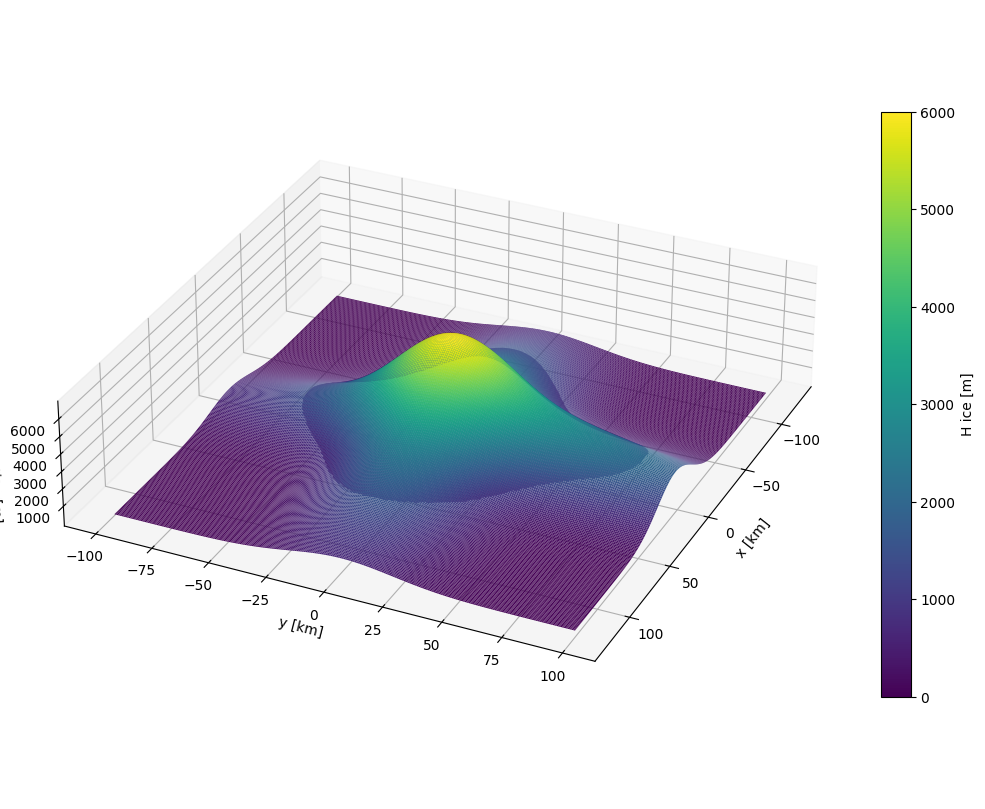

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Visualize bedrock and ice elevation
S_v = np.copy(S)
S_v[H <= 0.01] = np.nan
fig = plt.figure(figsize=(20, 12))
axs = fig.add_subplot(121, projection='3d')
axs.set_xlabel("x [km]")
axs.set_ylabel("y [km]")
axs.set_zlabel("elevation [m]")
xic, yic = np.meshgrid(xc, yc)
axs.set_box_aspect((4, 4, 1))
axs.view_init(azim=25)
p1 = axs.plot_surface(xic / 1e3, yic / 1e3, B, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
p2 = axs.plot_surface(xic / 1e3, yic / 1e3, S_v, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
norm = mpl.colors.Normalize(vmin=0, vmax=6000)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'),
         ax=axs, orientation='vertical', label='H ice [m]', shrink=0.5)
plt.tight_layout()
plt.show()